# Databroker example: area detector image

**Objective**:
Find an area detector (2-D) image from data collected previously.  Find the center of the bright spot in the image.

*Note*: This bluesky data was exported from a different database.  It's an example of working with Bluesky data exported from the APS.

First, a couple lines to make the graphics work here.

In [1]:
try:
    %load_ext dotenv
    %dotenv env.txt
except Exception:
    print(
        "Did not load file with environment variables."
        "  No problem.  Continuing ..."
    )

Did not load file with environment variables.  No problem.  Continuing ...


Import the libraries needed for this example.  Note that the `bluesky`, `ophyd`, and `epics` (PyEpics) packages are not needed.

In [2]:
import databroker
from scipy import ndimage
from apstools.utils import listruns

cat = databroker.catalog["class_data_examples"]
print(f"{len(cat) = }")

len(cat) = 59


Print a list of the runs in this databroker catalog of example data.  The default is to show 20 runs.  Change that to show all (by giving a number that is obviously more than the example data holds).

In [3]:
listruns(db=cat, num=100)

catalog: class_data_examples


,scan_id,time,plan_name,detectors
0,90,2021-03-06 14:16:41,scan,[noisy]
1,89,2021-03-06 14:15:35,scan,[noisy]
2,88,2021-03-06 14:14:45,scan,[noisy]
3,87,2021-03-06 14:13:44,scan,[noisy]
4,86,2021-03-06 14:10:46,rel_scan,[noisy]
5,85,2021-03-06 14:10:43,rel_scan,[noisy]
6,84,2021-03-06 14:10:37,rel_scan,[noisy]
7,83,2021-03-06 14:10:19,rel_scan,[noisy]
8,82,2021-03-03 10:01:32,count,[adsimdet]
9,81,2021-03-03 09:50:41,count,[adsimdet]


## Select the run

Get the run with `scan_id=82` from the databroker catalog of example data.

run = cat.search({"scan_id": 82})[-1]
run

There is an easier way to search for a `scan_id`.  Treat the `cat` object as if it were a list and pick by `scan_id`:

In [5]:
run = cat[82]
run

BlueskyRun
  uid='eb1924b3-b051-4709-8d38-98a4bce487fc'
  exit_status='success'
  2021-03-03 10:01:32.162 -- 2021-03-03 10:01:32.864
  Streams:
    * baseline
    * primary


## Get datasets
Get the datasets from the *primary* stream.

In [6]:
ds = run.primary.read()
ds

<xarray.Dataset>
Dimensions:         (dim_0: 1, dim_1: 1024, dim_2: 1024, time: 1)
Coordinates:
  * time            (time) float64 1.615e+09
Dimensions without coordinates: dim_0, dim_1, dim_2
Data variables:
    adsimdet_image  (time, dim_0, dim_1, dim_2) uint8 6 6 6 6 7 6 ... 6 6 6 6 8

## Get image frame data
The data to examine is `adsimdet_image`.  It's the only one.  We have to dereference two indices for how the frame was packed by EPICS area detector into the HDF5 file.  Also, the *scipy* package wants to receive a numpy `ndarray` so we must convert from the `xarray.Dataset`.

In [7]:
frame = ds["adsimdet_image"][0][0]
np_frame = frame.data
np_frame

array([[6, 6, 6, ..., 7, 7, 6],
       [6, 8, 6, ..., 7, 7, 7],
       [6, 8, 7, ..., 6, 6, 7],
       ...,
       [6, 7, 7, ..., 7, 8, 7],
       [7, 7, 6, ..., 7, 8, 7],
       [8, 6, 7, ..., 6, 6, 8]], dtype=uint8)

# Analysis
Print some basic measures of this image frame.

In [8]:
print(f"{ndimage.measurements.center_of_mass(np_frame)   = }")
print(f"{ndimage.measurements.maximum_position(np_frame) = }")
print(f"{np_frame.max() = }")
print(f"{np_frame.min() = }")

ndimage.measurements.center_of_mass(np_frame)   = (499.31197663869756, 470.83827886798076)
ndimage.measurements.maximum_position(np_frame) = (422, 230)
np_frame.max() = 157
np_frame.min() = 6


## Visualize
Show the frame as an image.The `xarray.Dataset` has a plot method.

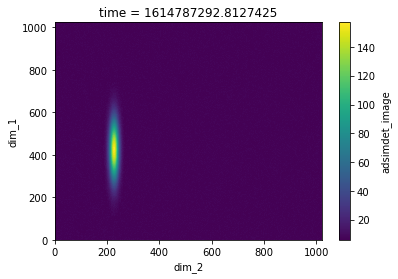

In [7]:
frame.plot.pcolormesh()

## Next Steps

Make these additions or improvements:

1. Repeat the same analysis for *all* area detector images in the catalog.  (hint: `for uid in catalog: run = catalog[uid] ...`)
1. Computed `center_of_mass` and `maximum_position` do not agree.  Explain why.
1. Sort the catalog based on some metadata key such as `scan_id` (hint: `run.metadata["start"][key]`)
1. Determine the 2-D width of the bright spot.
1. The runs involving `noisy` *v* `m1` have a peak.  Find center and width of one run.  Repeat for all such runs.
1. For any run with `temperature`, compute the average temperature and its standard deviation.  Repeat for all such runs.
1. For all runs in the catalog, print relevant summary analysis for each.  Include `scan_id` and starting time in the report.